In [1]:
import numpy as np
np.seterr(all='raise')

import matplotlib.pyplot as plt

from scipy.integrate import fixed_quad, quadrature, quad, nquad

import sys

sys.path.append("../Codes/")
from Hall1997 import *

In [2]:
mu = 1
sigma = 1
a = 1.5
theta = 0.1

upper_bdy = lambda t: a - theta * t
lower_bdy = lambda t: -a + theta * t

$X_t$ is an 1D stochastic process, let $\mathcal{T}=\inf\{t\ge0: X_t\ge l(t)\text{ or }X_t\ge u(t)\}$. We want to study the stopped process $X_{t\wedge\mathcal{T}}$. Let $p(x,t|y,s)$ be the transition probability density of $X_{t\wedge\mathcal{T}}$, defined as $p(x,t|y,s)\mathrm{d}x=\mathbb{P}(X_{t\wedge \mathcal{T}}\in\mathrm{d}x|X_{s\wedge \mathcal{T}}=y)$.



The Chapman-Kolmogorov equation writes
$$
p(x,t|y,s)=\int p(z,r|y,s)p(x, t|z,r)\mathrm{d}z
$$
for $s\le r\le t$. We want to numerically verify this.


In [3]:
# p = lambda T, x0, x, a: density_vertical(x, mu=mu, a=a, b=theta, x0=x0, T=T, trunc_num=35, if_logsumexp=False)
p = lambda x, t, y, s: density_vertical(
    x, mu=mu, a=a - theta * s, b=theta, x0=y, T=t - s, trunc_num=35, if_logsumexp=False
)

For our case, let $l(0)\le x^{(0)}\le u(0)$ be fixed, C-K equation becomes
$$
\begin{aligned}
p(x^{(2)},t^{(2)}|x^{(0)},0)&=\int_{l(t^{(1)})}^{u(t^{(1)})} p(x^{(1)},t^{(1)}|x^{(0)}, 0)p(x^{(2)},t^{(2)}|x^{(1)},t^{(1)}) \mathrm{d}x^{(1)}\\
& \text{for  }l(t^{(2)})\le x^{(2)}\le u(t^{(2)})\\
p(x^{(3)},t^{(3)}|x^{(0)},0)&=\int_{l(t^{(2)})}^{u(t^{(2)})}\int_{l(t^{(1)})}^{u(t^{(1)})} p(x^{(1)},t^{(1)}|x^{(0)}, 0)p(x^{(2)},t^{(2)}|x^{(1)},t^{(1)})p(x^{(3)},t^{(3)}|x^{(2)},t^{(2)})\mathrm{d}x^{(1)}\mathrm{d}x^{(2)}\\
&\text{for  }l(t^{(3)})\le x^{(3)}\le u(t^{(3)})\\
p(x^{(4)},t^{(4)}|x^{(0)},0)&=\int_{l(t^{(3)})}^{u(t^{(3)})}\int_{l(t^{(2)})}^{u(t^{(2)})}\int_{l(t^{(1)})}^{u(t^{(1)})} p(x^{(1)},t^{(1)}|x^{(0)}, 0)p(x^{(2)},t^{(2)}|x^{(1)},t^{(1)})p(x^{(3)},t^{(3)}|x^{(2)},t^{(2)})p(x^{(4)},t^{(4)}|x^{(3)},t^{(3)}) \mathrm{d}x^{(1)}\mathrm{d}x^{(2)}\mathrm{d}x^{(3)}\\
&\text{for }l(t^{(4)})\le x^{(4)}\le u(t^{(4)})\\
&\cdots
\end{aligned}
$$
We can calculate the integral via multi-dimensional Gauss-Legendre quadrature. Note that the above can be easily integrated to get the formula for the case where the density of $X_0$ is $f(x)$ instead of $\delta(x-x_0)$.

In [4]:
# collapse at a / theta = 10
T1, T2, T3, T4 = 1, 3, 1.5, 2
t1, t2, t3, t4 = np.cumsum([T1, T2, T3, T4])
x0 = -0.3

In [5]:
# utility function, Gauss-Legendre quadrature in 2D and 3D
# test result: not as robust as scipy.integrate.nquad for weird functions, but thousands times faster


def Gauss_quad_2D(f, quad_range, order=5):
    (xl, xu), (yl, yu) = quad_range
    quad_points_ref, quad_weights = np.polynomial.legendre.leggauss(order)
    x_quad_points = quad_points_ref * (xu - xl) / 2 + (xu + xl) / 2
    y_quad_points = quad_points_ref * (yu - yl) / 2 + (yu + yl) / 2
    xv, yv = np.meshgrid(x_quad_points, y_quad_points, sparse=True, indexing="ij")
    weights = quad_weights[:, None] * quad_weights[None, :]
    return np.sum(np.multiply(f(xv, yv), weights)) * (xu - xl) * (yu - yl) / 4


def Gauss_quad_3D(f, quad_range, order=5):
    (xl, xu), (yl, yu), (zl, zu) = quad_range
    quad_points_ref, quad_weights = np.polynomial.legendre.leggauss(order)
    x_quad_points = quad_points_ref * (xu - xl) / 2 + (xu + xl) / 2
    y_quad_points = quad_points_ref * (yu - yl) / 2 + (yu + yl) / 2
    z_quad_points = quad_points_ref * (zu - zl) / 2 + (zu + zl) / 2
    xv, yv, zv = np.meshgrid(
        x_quad_points, y_quad_points, z_quad_points, sparse=True, indexing="ij"
    )
    weights = (
        quad_weights[:, None, None]
        * quad_weights[None, :, None]
        * quad_weights[None, None, :]
    )
    return (
        np.sum(np.multiply(f(xv, yv, zv), weights))
        * (xu - xl)
        * (yu - yl)
        * (zu - zl)
        / 8
    )


def Gauss_quad_nD(f, quad_range, order=5):
    quad_range = np.array(quad_range)
    d = len(quad_range)
    quad_points_ref, quad_weights = np.polynomial.legendre.leggauss(order)
    quad_points = np.zeros((d, len(quad_points_ref)))
    for i in range(d):
        quad_points[i] = (
            quad_points_ref * (quad_range[i, 1] - quad_range[i, 0]) / 2
            + (quad_range[i, 1] + quad_range[i, 0]) / 2
        )
    grids = np.meshgrid(*quad_points, sparse=True, indexing="ij")
    _weights = np.meshgrid(*np.tile(quad_weights, [d, 1]), indexing="ij")
    weights = np.prod(np.array(_weights), axis=0)
    return (
        np.sum(np.multiply(f(*grids), weights))
        * np.prod(quad_range[:, 1] - quad_range[:, 0])
        / 2**d
    )

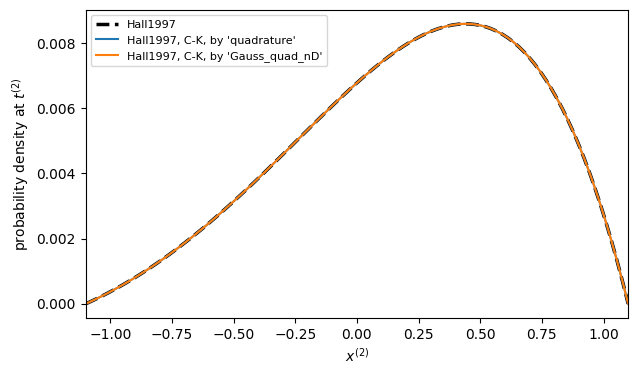

In [6]:
# Gaussian Quadrature, two stage time marching

x2s = np.linspace(lower_bdy(t2), upper_bdy(t2), num=100)
p2s = []
p2s_quad = []
p2s_gquad_nD = []
for x2 in x2s:
    p2s.append(p(x2, t2, x0, 0))
    integrand = lambda x1: p(x1, t1, x0, 0) * p(x2, t2, x1, t1)
    p2s_quad.append(quadrature(integrand, lower_bdy(t1), upper_bdy(t1))[0])
    p2s_gquad_nD.append(Gauss_quad_nD(integrand, [[lower_bdy(t1), upper_bdy(t1)]]))

fig, ax = plt.subplots(figsize=(7, 4), dpi=100)
ax.plot(x2s, p2s, color="k", linestyle="--", linewidth=2.5, label="Hall1997")
ax.plot(x2s, p2s_quad, label="Hall1997, C-K, by 'quadrature'")
ax.plot(x2s, p2s_gquad_nD, label="Hall1997, C-K, by 'Gauss_quad_nD'")
ax.legend(fontsize=8)
ax.set_xlabel("$x^{(2)}$")
ax.set_ylabel("probability density at $t^{(2)}$")
ax.autoscale(tight=True, axis="x")
plt.show()

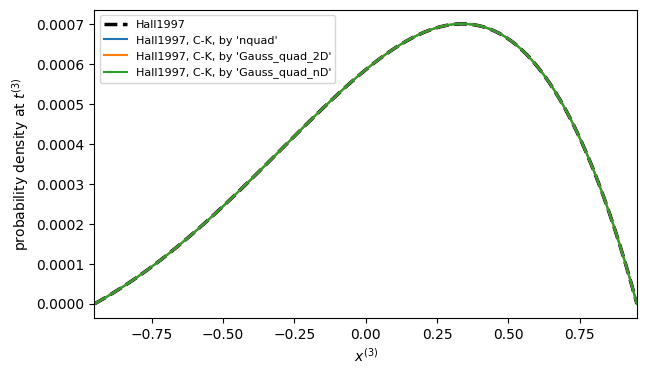

In [7]:
# Gaussian Quadrature, three stage time marching

x3s = np.linspace(lower_bdy(t3), upper_bdy(t3), num=100)
p3s = []
p3s_nquad = []
p3s_gquad_2D = []
p3s_gquad_nD = []
for x3 in x3s:
    p3s.append(p(x3, t3, x0, 0))
    integrand = lambda x1, x2: p(x1, t1, x0, 0) * p(x2, t2, x1, t1) * p(x3, t3, x2, t2)
    p3s_nquad.append(
        nquad(
            integrand,
            [[lower_bdy(t1), upper_bdy(t1)], [lower_bdy(t2), upper_bdy(t2)]],
        )[0]
    )
    p3s_gquad_2D.append(
        Gauss_quad_2D(
            integrand,
            [[lower_bdy(t1), upper_bdy(t1)], [lower_bdy(t2), upper_bdy(t2)]],
        )
    )
    p3s_gquad_nD.append(
        Gauss_quad_nD(
            integrand,
            [[lower_bdy(t1), upper_bdy(t1)], [lower_bdy(t2), upper_bdy(t2)]],
        )
    )

fig, ax = plt.subplots(figsize=(7, 4), dpi=100)
ax.plot(x3s, p3s, color="k", linestyle="--", linewidth=2.5, label="Hall1997")
ax.plot(x3s, p3s_nquad, label="Hall1997, C-K, by 'nquad'")
ax.plot(x3s, p3s_gquad_2D, label="Hall1997, C-K, by 'Gauss_quad_2D'")
ax.plot(x3s, p3s_gquad_nD, label="Hall1997, C-K, by 'Gauss_quad_nD'")
ax.legend(fontsize=8)
ax.set_xlabel("$x^{(3)}$")
ax.set_ylabel("probability density at $t^{(3)}$")
ax.autoscale(tight=True, axis="x")
plt.show()

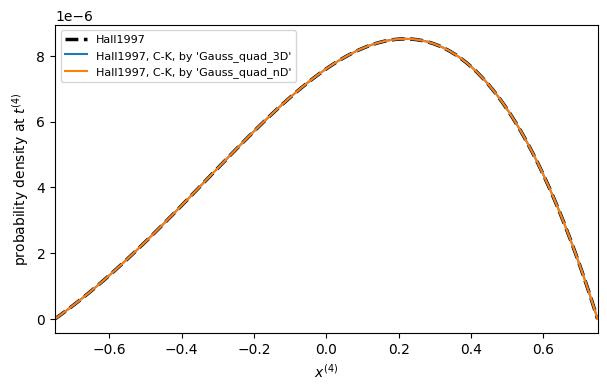

In [8]:
# Gaussian Quadrature, four stage time marching

x4s = np.linspace(lower_bdy(t4), upper_bdy(t4), num=100)
p4s = []
p4s_nquad = []  # takes 4 minutes
p4s_gquad_3D = []  # takes fraction of a second
p4s_gquad_nD = []
for x4 in x4s:
    p4s.append(p(x4, t4, x0, 0))
    integrand = (
        lambda x1, x2, x3: p(x1, t1, x0, 0)
        * p(x2, t2, x1, t1)
        * p(x3, t3, x2, t2)
        * p(x4, t4, x3, t3)
    )
    # # commented, this computation takes too much time
    # p4s_nquad.append(
    #     nquad(
    #         integrand,
    #         [
    #             [lower_bdy(t1), upper_bdy(t1)],
    #             [lower_bdy(t2), upper_bdy(t2)],
    #             [lower_bdy(t3), upper_bdy(t3)],
    #         ],
    #     )[0]
    # )
    p4s_gquad_3D.append(
        Gauss_quad_3D(
            integrand,
            [
                [lower_bdy(t1), upper_bdy(t1)],
                [lower_bdy(t2), upper_bdy(t2)],
                [lower_bdy(t3), upper_bdy(t3)],
            ],
        )
    )
    p4s_gquad_nD.append(
        Gauss_quad_nD(
            integrand,
            [
                [lower_bdy(t1), upper_bdy(t1)],
                [lower_bdy(t2), upper_bdy(t2)],
                [lower_bdy(t3), upper_bdy(t3)],
            ],
        )
    )

fig, ax = plt.subplots(figsize=(7, 4), dpi=100)
ax.plot(x4s, p4s, color="k", linestyle="--", linewidth=2.5, label="Hall1997")
# ax.plot(x4s, p4s_nquad, label="Hall1997, C-K, by 'nquad'")
ax.plot(x4s, p4s_gquad_3D, label="Hall1997, C-K, by 'Gauss_quad_3D'")
ax.plot(x4s, p4s_gquad_nD, label="Hall1997, C-K, by 'Gauss_quad_nD'")
ax.legend(fontsize=8)
ax.set_xlabel("$x^{(4)}$")
ax.set_ylabel("probability density at $t^{(4)}$")
ax.autoscale(tight=True, axis="x")
plt.show()

In [9]:
# time comparison
x4_test = 0.2
integrand = (
        lambda x1, x2, x3: p(x1, t1, x0, 0)
        * p(x2, t2, x1, t1)
        * p(x3, t3, x2, t2)
        * p(x4_test, t4, x3, t3)
    )
%timeit -r 5 -n 1 nquad(integrand,[[lower_bdy(t1), upper_bdy(t1)],[lower_bdy(t2), upper_bdy(t2)],[lower_bdy(t3), upper_bdy(t3)]])

%timeit -r 5 -n 100 Gauss_quad_3D(integrand,[[lower_bdy(t1), upper_bdy(t1)],[lower_bdy(t2), upper_bdy(t2)],[lower_bdy(t3), upper_bdy(t3)]])

%timeit -r 5 -n 100 Gauss_quad_nD(integrand,[[lower_bdy(t1), upper_bdy(t1)],[lower_bdy(t2), upper_bdy(t2)],[lower_bdy(t3), upper_bdy(t3)]])

3.52 s ± 25.4 ms per loop (mean ± std. dev. of 5 runs, 1 loop each)
1.41 ms ± 8 µs per loop (mean ± std. dev. of 5 runs, 100 loops each)
1.48 ms ± 18.3 µs per loop (mean ± std. dev. of 5 runs, 100 loops each)


By the composite trapizodal rule on uniform grid $l(r)=z_0<z_1<\cdots<z_N= u(r)$ and $\Delta z=z_{k+1}-z_k$, we have
$$
\begin{aligned}
p(x,t|y,s)&=\int p(z,r|y,s)p(x, t|z,r)\mathrm{d}z\\
&\approx \Delta x\left[\sum_{k=1}^{N-1} p(z_k,r|y,s)p(x, t|z_k,r)+\tfrac{1}{2}\left(p(z_0,r|y,s)p(x, t|z_0,r)+p(z_N,r|y,s)p(x, t|z_N,r)\right)\right]\\
&=\Delta x\sum_{k=1}^{N-1} p(z_k,r|y,s)p(x, t|z_k,r)
\end{aligned}
$$
The last step is from the absorbing boundary condition $p(l(t),t|y,s)=p(u(t),t|y,s)=0$ for any $t$. So in our case
$$
\begin{aligned}
\text{For  }l(t^{(1)})\le x^{(1)}\le u(t^{(1)}),\ p(x^{(1)},t^{(1)}|x^{(0)},0)&=\text{analytical}\\
\text{For  }l(t^{(2)})\le x^{(2)}\le u(t^{(2)}),\ p(x^{(2)},t^{(2)}|x^{(0)},0)&=\int_{l(t^{(1)})}^{u(t^{(1)})} p(x^{(1)},t^{(1)}|x^{(0)}, 0)p(x^{(2)},t^{(2)}|x^{(1)},t^{(1)}) \mathrm{d}x^{(1)} \\
&\approx \Delta x^{(1)}\sum_{k=1}^{N-1} p(x^{(1)}_k,t^{(1)}|x^{(0)}, 0)p(x^{(2)},t^{(2)}|x^{(1)}_k,t^{(1)})\\

\text{For  }l(t^{(3)})\le x^{(3)}\le u(t^{(3)}),\ p(x^{(3)},t^{(3)}|x^{(0)},0)&=\int_{l(t^{(2)})}^{u(t^{(2)})}p(x^{(2)},t^{(2)}|x^{(0)},0)p(x^{(3)},t^{(3)}|x^{(2)},t^{(2)})\mathrm{d}x^{(2)}\\
&\approx \Delta x^{(2)}\sum_{k=1}^{N-1} p(x^{(2)}_k,t^{(2)}|x^{(0)}, 0)p(x^{(3)},t^{(3)}|x^{(2)}_k,t^{(2)})\\
\text{For  }l(t^{(4)})\le x^{(4)}\le u(t^{(4)}),\ p(x^{(4)},t^{(4)}|x^{(0)},0)&=\int_{l(t^{(3)})}^{u(t^{(3)})}p(x^{(3)},t^{(3)}|x^{(0)},0)p(x^{(4)},t^{(4)}|x^{(3)},t^{(3)}) \mathrm{d}x^{(3)}\\
&\approx \Delta x^{(3)}\sum_{k=1}^{N-1} p(x^{(3)}_k,t^{(3)}|x^{(0)}, 0)p(x^{(4)},t^{(4)}|x^{(3)}_k,t^{(3)})\\
&\cdots
\end{aligned}
$$


In [10]:
x1s = np.linspace(lower_bdy(t1), upper_bdy(t1), num=100)
p1s_trapz = []
for x1 in x1s:
    p1s_trapz.append(p(x1, t1, x0, 0))

p2s_trapz = []
for x2 in x2s:
    result = 0
    for i in range(1, len(x1s) - 1):
        result += p1s_trapz[i] * p(x2, t2, x1s[i], t1)
    result *= x1s[1] - x1s[0]
    p2s_trapz.append(result)

p3s_trapz = []
for x3 in x3s:
    result = 0
    for i in range(1, len(x2s) - 1):
        result += p2s[i] * p(x3, t3, x2s[i], t2)
    result *= x2s[1] - x2s[0]
    p3s_trapz.append(result)

p4s_trapz = []
for x4 in x4s:
    result = 0
    for i in range(1, len(x3s) - 1):
        result += p3s[i] * p(x4, t4, x3s[i], t3)
    result *= x3s[1] - x3s[0]
    p4s_trapz.append(result)

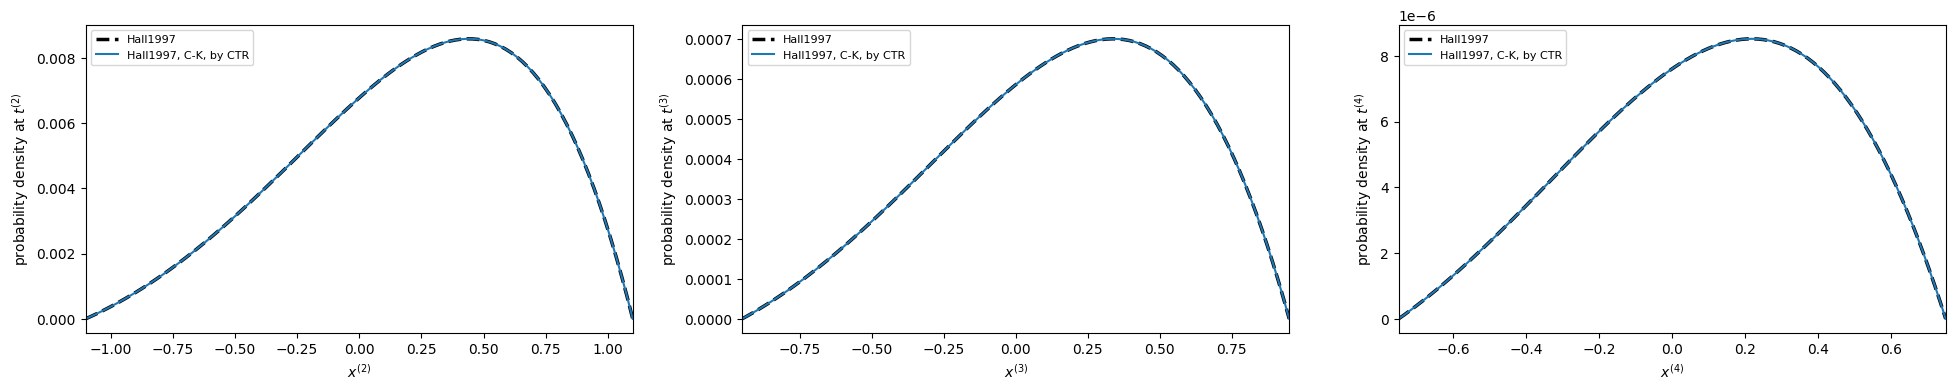

In [11]:
fig, ax = plt.subplots(1, 3, figsize=(24, 4), dpi=100)
ax[0].plot(x2s, p2s, color="k", linestyle="--", linewidth=2.5, label="Hall1997")
ax[0].plot(x2s, p2s_trapz, label="Hall1997, C-K, by CTR")
ax[0].legend(fontsize=8)
ax[0].set_xlabel("$x^{(2)}$")
ax[0].set_ylabel("probability density at $t^{(2)}$")
ax[0].autoscale(tight=True, axis="x")

ax[1].plot(x3s, p3s, color="k", linestyle="--", linewidth=2.5, label="Hall1997")
ax[1].plot(x3s, p3s_trapz, label="Hall1997, C-K, by CTR")
ax[1].legend(fontsize=8)
ax[1].set_xlabel("$x^{(3)}$")
ax[1].set_ylabel("probability density at $t^{(3)}$")
ax[1].autoscale(tight=True, axis="x")

ax[2].plot(x4s, p4s, color="k", linestyle="--", linewidth=2.5, label="Hall1997")
ax[2].plot(x4s, p4s_trapz, label="Hall1997, C-K, by CTR")
ax[2].legend(fontsize=8)
ax[2].set_xlabel("$x^{(4)}$")
ax[2].set_ylabel("probability density at $t^{(4)}$")
ax[2].autoscale(tight=True, axis="x")

plt.show()

we also have the first passage time densities at the upper boundary and lower boundary, $f_u(t|y, s)$ and $f_l(t|y, s)$ respectively

By a similar manner, we have
$$
\begin{aligned}
f_u(t|x^{(0)},0)&=\int_{l(t^{(1)})}^{u(t^{(1)})} p(x^{(1)},t^{(1)}|x^{(0)}, 0)f_u(t|x^{(1)}, t^{(1)}) \mathrm{d}x^{(1)}, \text{ for } t^{(1)}\le t\le t^{(2)}\\
f_u(t|x^{(0)},0)&=\int_{l(t^{(2)})}^{u(t^{(2)})} p(x^{(2)},t^{(2)}|x^{(0)}, 0)f_u(t|x^{(2)}, t^{(2)}) \mathrm{d}x^{(2)}\\
&=\int_{l(t^{(2)})}^{u(t^{(2)})} \int_{l(t^{(1)})}^{u(t^{(1)})} p(x^{(1)},t^{(1)}|x^{(0)}, 0)p(x^{(2)},t^{(2)}|x^{(1)},t^{(1)}) f_u(t|x^{(2)}, t^{(2)}) \mathrm{d}x^{(1)}\mathrm{d}x^{(2)}, \text{ for } t^{(2)}\le t\le t^{(3)}\\
f_u(t|x^{(0)},0)&=\int_{l(t^{(3)})}^{u(t^{(3)})} p(x^{(3)},t^{(3)}|x^{(0)}, 0)f_u(t|x^{(3)}, t^{(3)}) \mathrm{d}x^{(3)}\\
&=\int_{l(t^{(3)})}^{u(t^{(3)})} \int_{l(t^{(2)})}^{u(t^{(2)})}\int_{l(t^{(1)})}^{u(t^{(1)})} p(x^{(1)},t^{(1)}|x^{(0)}, 0)p(x^{(2)},t^{(2)}|x^{(1)},t^{(1)})p(x^{(3)},t^{(3)}|x^{(2)},t^{(2)})f_u(t|x^{(3)}, t^{(3)}) \mathrm{d}x^{(1)}\mathrm{d}x^{(2)}\mathrm{d}x^{(3)}, \text{ for } t^{(3)}\le t\le t^{(4)}\\
\end{aligned}
$$
the formula is similar for $f_l(t|x_0,0)$.

In [12]:
fu = lambda t, y, s: density_upper(
    t-s, mu=mu, a=a - theta * s, b=theta, x0=y, trunc_num=100
)
fl = lambda t, y, s: density_lower(
    t-s, mu=mu, a=a - theta * s, b=theta, x0=y, trunc_num=100
)

In [13]:
eps = 1e-36
ts = np.linspace(1e-8, t4-eps, 100)

probu_list = []
for t in ts:
    probu_list.append(fu(t, x0, 0))

probl_list = []
for t in ts:
    probl_list.append(fl(t, x0, 0))

FloatingPointError: underflow encountered in exp

In [ ]:
t1s = np.linspace(eps, t1 - eps, 100)
p1u_list = []
for t in t1s:
    p1u_list.append(fu(t, x0, 0))
p1l_list = []
for t in t1s:
    p1l_list.append(fl(t, x0, 0))

t2s = np.linspace(t1 + eps, t2 - eps, 100)
p2u_list = []
for t in t2s:
    integrand = lambda x1: p(x1, t1, x0, 0) * fu(t, x1, t1)
    p2u_list.append(Gauss_quad_nD(integrand, [[lower_bdy(t1), upper_bdy(t1)]]))
p2l_list = []
for t in t2s:
    integrand = lambda x1: p(x1, t1, x0, 0) * fl(t, x1, t1)
    p2l_list.append(Gauss_quad_nD(integrand, [[lower_bdy(t1), upper_bdy(t1)]]))

t3s = np.linspace(t2 + eps, t3 - eps, 100)
p3u_list = []
for t in t3s:
    integrand = lambda x1, x2: p(x2, t2, x1, t1) * p(x1, t1, x0, 0) * fu(t, x2, t2)
    p3u_list.append(
        Gauss_quad_nD(
            integrand, [[lower_bdy(t1), upper_bdy(t1)], [lower_bdy(t2), upper_bdy(t2)]]
        )
    )
p3l_list = []
for t in t3s:
    integrand = lambda x1, x2: p(x2, t2, x1, t1) * p(x1, t1, x0, 0) * fl(t, x2, t2)
    p3l_list.append(
        Gauss_quad_nD(
            integrand, [[lower_bdy(t1), upper_bdy(t1)], [lower_bdy(t2), upper_bdy(t2)]]
        )
    )

t4s = np.linspace(t3 + eps, t4 - eps, 100)
p4u_list = []
for t in t4s:
    integrand = (
        lambda x1, x2, x3: p(x3, t3, x2, t2)
        * p(x2, t2, x1, t1)
        * p(x1, t1, x0, 0)
        * fu(t, x3, t3)
    )
    p4u_list.append(
        Gauss_quad_nD(
            integrand,
            [
                [lower_bdy(t1), upper_bdy(t1)],
                [lower_bdy(t2), upper_bdy(t2)],
                [lower_bdy(t3), upper_bdy(t3)],
            ],
        )
    )
p4l_list = []
for t in t4s:
    integrand = (
        lambda x1, x2, x3: p(x3, t3, x2, t2)
        * p(x2, t2, x1, t1)
        * p(x1, t1, x0, 0)
        * fl(t, x3, t3)
    )
    p4l_list.append(
        Gauss_quad_nD(
            integrand,
            [
                [lower_bdy(t1), upper_bdy(t1)],
                [lower_bdy(t2), upper_bdy(t2)],
                [lower_bdy(t3), upper_bdy(t3)],
            ],
        )
    )

../Codes/Hall1997.py:19: RuntimeWarning: divide by zero encountered in double_scalars
  / sqrt(2 * pi)
../Codes/Hall1997.py:24: RuntimeWarning: divide by zero encountered in double_scalars
  term = (-1) ** j * rj * exp(0.5 * (b / a - 1 / t) * rj**2)
../Codes/Hall1997.py:28: RuntimeWarning: invalid value encountered in multiply
  return result * factor
../Codes/Hall1997.py:40: RuntimeWarning: divide by zero encountered in double_scalars
  / sqrt(2 * pi)
../Codes/Hall1997.py:45: RuntimeWarning: divide by zero encountered in double_scalars
  term = (-1) ** j * rj * exp(0.5 * (b / a - 1 / t) * rj**2)
../Codes/Hall1997.py:49: RuntimeWarning: invalid value encountered in multiply
  return result * factor


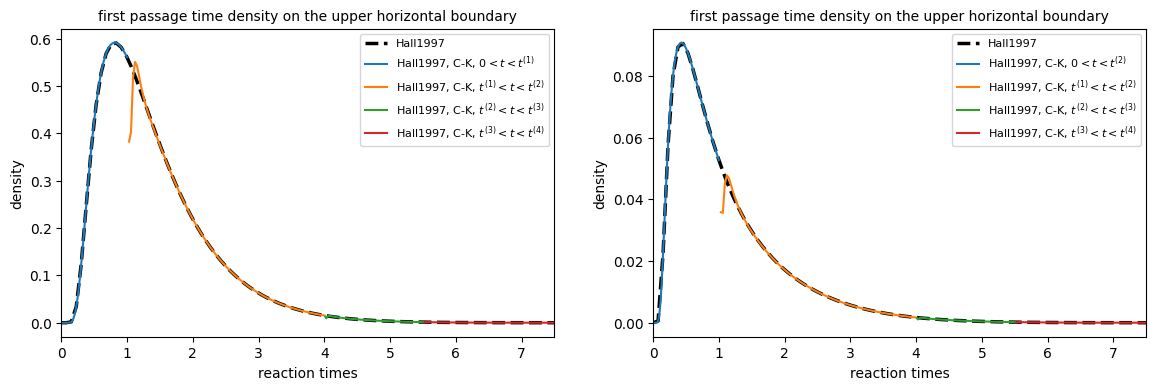

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(14, 4), dpi=100)
ax[0].plot(ts, probu_list, color="k", linestyle="--", linewidth=2.5, label="Hall1997")
ax[0].plot(t1s, p1u_list, label="Hall1997, C-K, " + "$0 <t<t^{(1)}$")
ax[0].plot(t2s, p2u_list, label="Hall1997, C-K, " + "$t^{(1)}<t<t^{(2)}$")
ax[0].plot(t3s, p3u_list, label="Hall1997, C-K, " + "$t^{(2)}<t<t^{(3)}$")
ax[0].plot(t4s, p4u_list, label="Hall1997, C-K, " + "$t^{(3)}<t<t^{(4)}$")
ax[0].legend(fontsize=8)
ax[0].set_title(
    "first passage time density on the upper horizontal boundary", fontsize=10
)
ax[0].set_xlabel("reaction times")
ax[0].set_ylabel("density")
ax[0].autoscale(tight=True, axis="x")

ax[1].plot(ts, probl_list, color="k", linestyle="--", linewidth=2.5, label="Hall1997")
ax[1].plot(t1s, p1l_list, label="Hall1997, C-K, " + "$0<t<t^{(2)}$")
ax[1].plot(t2s, p2l_list, label="Hall1997, C-K, " + "$t^{(1)}<t<t^{(2)}$")
ax[1].plot(t3s, p3l_list, label="Hall1997, C-K, " + "$t^{(2)}<t<t^{(3)}$")
ax[1].plot(t4s, p4l_list, label="Hall1997, C-K, " + "$t^{(3)}<t<t^{(4)}$")
ax[1].legend(fontsize=8)
ax[1].set_title(
    "first passage time density on the upper horizontal boundary", fontsize=10
)
ax[1].set_xlabel("reaction times")
ax[1].set_ylabel("density")
ax[1].autoscale(tight=True, axis="x")

plt.show()

In [ ]:
p2u_list

[nan,
 0.38233988558800874,
 0.4025386850539736,
 0.5172784635399742,
 0.5508631108712213,
 0.5422413707355068,
 0.5213458366064765,
 0.4999648471147303,
 0.4811927556856007,
 0.46506705591068315,
 0.4508814018736345,
 0.4379488358342679,
 0.425777065969642,
 0.4140576983211531,
 0.40261481258399084,
 0.39135749648402246,
 0.38024564163832136,
 0.36926772911637995,
 0.35842722980243935,
 0.34773462633008984,
 0.3372029151477177,
 0.3268451892351746,
 0.3166734302180421,
 0.30669798381938734,
 0.2969274081463526,
 0.2873685152223651,
 0.27802650414390634,
 0.26890512993310633,
 0.2600068785139503,
 0.25133313316906725,
 0.24288432609329338,
 0.23466007307766087,
 0.22665929159719853,
 0.21888030360705477,
 0.21132092473160155,
 0.20397854157665615,
 0.19685017878162403,
 0.1899325572513502,
 0.18322214481611224,
 0.17671520038631522,
 0.17040781250608392,
 0.16429593306988605,
 0.1583754068478469,
 0.15264199736629466,
 0.1470914096075967,
 0.14171930992483406,
 0.1365213435099148,
 0.1

#### Some thoughts...
1. Numerical integration: Trapizodal vs Gauss, accurate but slow in high dimension
2. Monte Carlo (with importance sampling): less accurate but scalable, may be more useful when there are more time steps